# Create Koppen map

Data downloaded from 
https://figshare.com/articles/dataset/High-resolution_1_km_K_ppen-Geiger_maps_for_1901_2099_based_on_constrained_CMIP6_projections/21789074/1

https://www.gloh2o.org/koppen/

Paper from Beck
https://www.nature.com/articles/sdata2018214

Data have been downloaded and saved in Google Drive
https://drive.google.com/drive/folders/1e2tRj7WXnycS_EXVbo9pGR6I-o2-V0NL?usp=sharing

Github for reference:
https://github.com/salvah22/koppenclassification

Koppen wiki: https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification



In [9]:
import xarray as xr
import numpy as np

In [198]:
idir = '/Users/doan/MyDrive/share/2024/clim_class_data/' # google drive data (shared)

In [199]:
!ls /Users/doan/MyDrive/share/2024/clim_class_data/21789074/
!ls /Users/doan/MyDrive/share/2024/clim_class_data/21789074/climate_data_0p1/ 

climate_data_0p1  climate_data_1p0  koppen_geiger_tif
climate_data_0p5  koppen_geiger_nc
1901_1930 1931_1960 1961_1990 1991_2020 2041_2070 2071_2099


In [200]:
ifile = idir + '21789074/climate_data_1p0/1991_2020/ensemble_mean_1p0.nc'
ifile = idir + '21789074/climate_data_0p1/1991_2020/ensemble_mean_0p1.nc'
dc = xr.open_dataset(ifile)

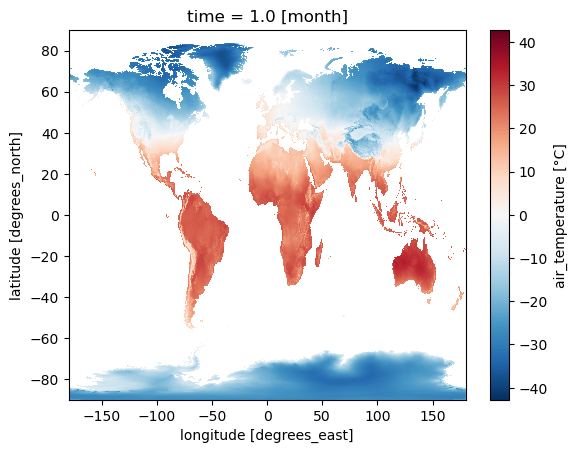

In [201]:
dc.air_temperature[0].plot()

In [194]:
t = dc.air_temperature # temperature
p = dc.precipitation # precipitation
lon, lat = np.meshgrid(dc.lon, dc.lat)
s = xr.DataArray(lat < 0, dims = ['lat', 'lon'], coords = {'lat':dc.lat, 'lon':dc.lon})

In [195]:
s # s is boolearn if south True, else False
# s have same frame with p, except having no time dimension


<xarray.DataArray (lat: 1800, lon: 3600)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float64 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.7 179.8 179.9

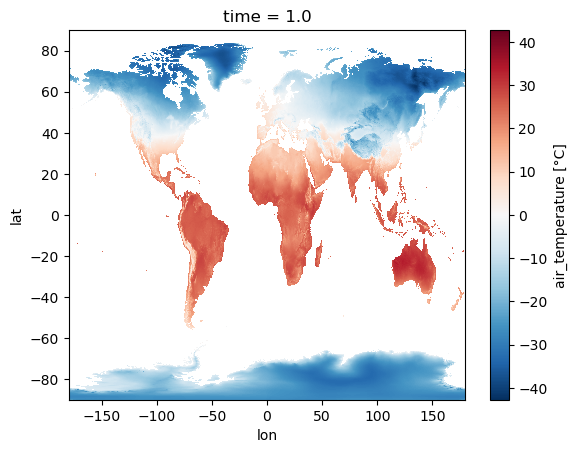

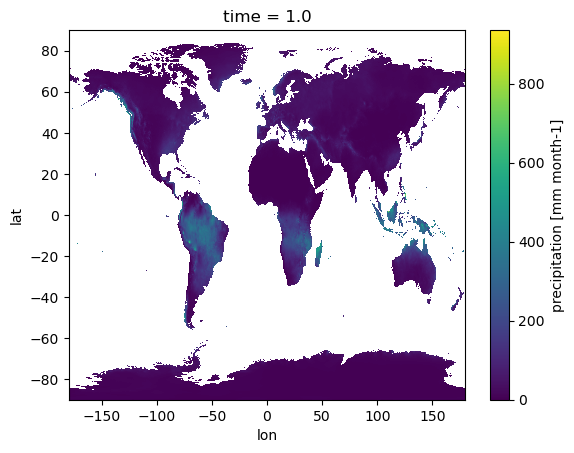

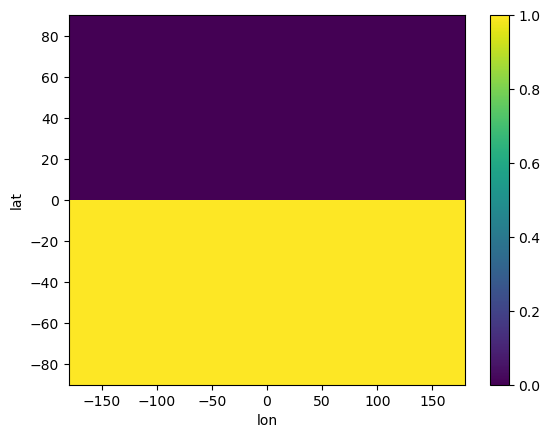

In [196]:
t[0].plot()
plt.show()
p[0].plot()
plt.show()
s.plot()

## Use apply ufunc

https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html




In [86]:
from koppen_class import koppen_vd

def koppen_classification_along_latlon(a, b, c):
    if np.isnan(a).any():
        return 'unknown'
    else:
        return koppen_vd(a,b,c) 

### Use apply ufunc to parallelly calculating

In [87]:
kpc = xr.apply_ufunc(koppen_classification_along_latlon, # this is the function defined above
                        p, t, s, # arguments of function (three arguments: precip, temp, and boolean south )
                        input_core_dims=[["time"], ["time"], []], # use array via dim "time" in precip, temp, and one value in south
                        output_core_dims=[[]], # output have one value
                        vectorize=True,  # seach line for more information
                        dask='allowed' # seach line for more information
                       )

In [191]:
# output have two dimensions 'lat', 'lon'
kpc

<xarray.DataArray (lat: 1800, lon: 3600)>
array([['unknown', 'unknown', 'unknown', ..., 'unknown', 'unknown',
        'unknown'],
       ['unknown', 'unknown', 'unknown', ..., 'unknown', 'unknown',
        'unknown'],
       ['unknown', 'unknown', 'unknown', ..., 'unknown', 'unknown',
        'unknown'],
       ...,
       ['EF', 'EF', 'EF', ..., 'EF', 'EF', 'EF'],
       ['EF', 'EF', 'EF', ..., 'EF', 'EF', 'EF'],
       ['EF', 'EF', 'EF', ..., 'EF', 'EF', 'EF']], dtype='<U7')
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95

### Convert symbol to number using Koppen_class_list excel file

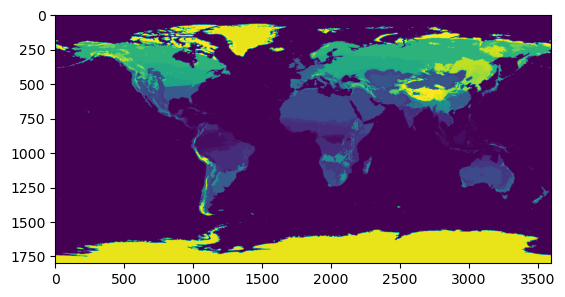

In [90]:
import pandas as pd
kp = pd.read_excel('Koppen_class_list.xlsx', index_col=1)
kp

x = np.zeros(kpc.shape)
for i, r in kp.iterrows():
    x = np.where(kpc == i, r['No'], x)
    
plt.imshow(x)

### Save to file

In [148]:
do = kp.set_index('No').to_xarray()
do['koppen_ind'] = ( ['lat', 'lon'], x) 
do.coords['lat'] = (('lat'),dc['lat'].values )
do.coords['lon'] = (('lon'),dc['lon'].values )
do.to_netcdf('koppen_vd_0p1.nc')

## Plot

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import from_levels_and_colors

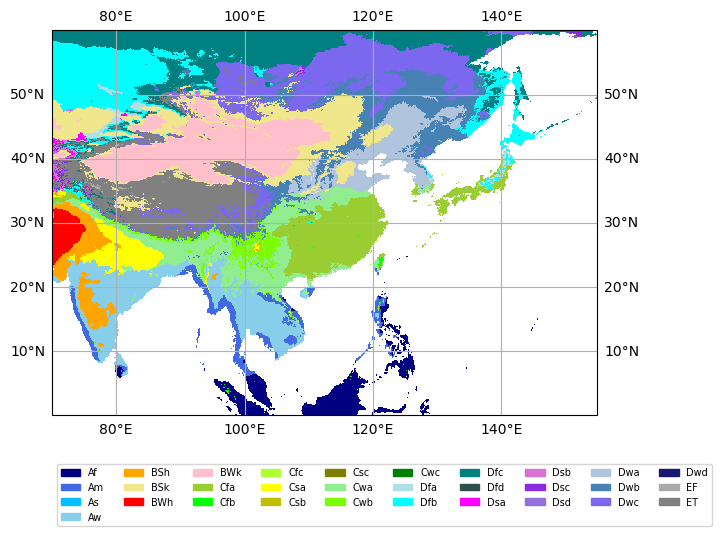

In [180]:
dx = do
kp = pd.read_excel('Koppen_class_list.xlsx', index_col=1)
lev = [.5]  + [ r['No'] + 0.5 for i, r in kp.iterrows()]
cols =    [ r['Color'] for i, r in kp.iterrows() ]
legend_handles = [ patches.Patch(color = r['Color'], label=i )  for i, r in kp.iterrows() ]

lon, lat = np.meshgrid(dx.lon, dx.lat)
data = dx.koppen_ind
cmap, norm = from_levels_and_colors(lev, cols)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
# Add geographic features
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax.set_extent([70, 155, 0, 60], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)
plt.legend(handles=legend_handles, loc='lower left', fontsize=7, ncols=10,
           bbox_to_anchor=(0, -.3))
# Show the plot
plt.title('')
plt.show()


### Plot orginal data downloaded






In [202]:
dk = xr.open_dataset(idir+'21789074/koppen_geiger_nc/1991_2020/koppen_geiger_0p1.nc')
kDict = {
    "Af": 1,"Am": 2,"Aw": 3, 
    "BWh": 4, "BWk": 5, "BSh": 6, "BSk": 7,
    "Csa": 8, "Csb": 9, "Csc": 10, "Cwa": 11, "Cwb": 12, "Cwc": 13, "Cfa": 14, "Cfb": 15, "Cfc": 16,
    "Dsa": 17, "Dsb": 18, "Dsc": 19, "Dsd": 20, "Dwa": 21, "Dwb": 22, "Dwc": 23, "Dwd": 24, "Dfa": 25, "Dfb": 26, "Dfc": 27, "Dfd": 28,
    "ET": 29, "EF": 30
}

In [203]:
data = dk.kg_class.values
lon, lat = np.meshgrid(dk.lon, dk.lat)
kp = pd.read_excel('Koppen_class_list.xlsx', index_col=1)
lev = [.5]  + [ r['No'] + 0.5 for i, r in kp.iterrows()]
cols =    [ r['Color'] for i, r in kp.iterrows() ]
legend_handles = [ patches.Patch(color = r['Color'], label=i )  for i, r in kp.iterrows() ]

In [204]:
kp

,No,Description,Group,Precipitation Type,Level of Heat,Color
Code,,,,,,
Af,1,Tropical rainforest climate,Tropical,Rainforest,NaN,navy
Am,2,Tropical monsoon climate,Tropical,Monsoon,NaN,royalblue
As,3,Tropical dry savanna climate,Tropical,"Savanna, Dry",NaN,deepskyblue
Aw,4,"Tropical savanna, wet",Tropical,"Savanna, Wet",NaN,skyblue
BSh,5,Hot semi-arid (steppe) climate,Arid,Steppe,Hot,orange
BSk,6,Cold semi-arid (steppe) climate,Arid,Steppe,Cold,khaki
BWh,7,Hot deserts climate,Arid,Desert,Hot,red
BWk,8,Cold desert climate,Arid,Desert,Cold,pink
Cfa,9,Humid subtropical climate,Temperate,Without dry season,Hot summer,yellowgreen


In [205]:
x = np.zeros(data.shape)
for k in list(kDict.keys()): x = np.where(data==kDict[k], kp.loc[k,'No'], x)

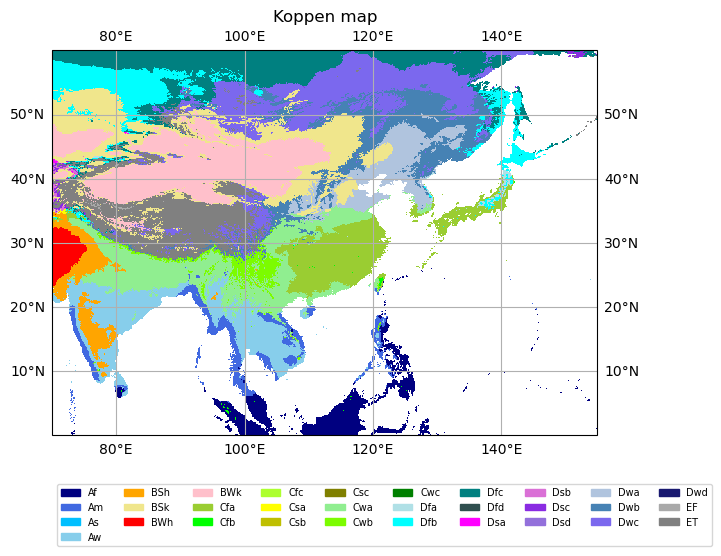

In [206]:
dat = x
# Define a colormap with specific colors for each category
cmap, norm = from_levels_and_colors(lev, cols)
# Create a plot with a specific projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(lon, lat, dat, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax.set_extent([70, 155, 0, 60], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
plt.legend(handles=legend_handles, loc='lower left', fontsize=7, ncols=10,
           bbox_to_anchor=(0, -.3))
plt.title('Koppen map')
plt.show()